In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [67]:

# Load the dataset
df = pd.read_excel("customer_transactions_sample.xlsx")
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [68]:
df.shape

(525461, 8)

In [69]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [71]:
## checking the descriptive statistics for columns with `float` and `int` d
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Quantity,525461.0,10.337667,-9600.0,1.0,3.0,10.0,19152.0,107.42411
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-12-09 20:01:00,NaN
Price,525461.0,4.688834,-53594.36,1.25,2.1,4.21,25111.09,146.126914
Customer ID,417534.0,15360.645478,12346.0,13983.0,15311.0,16799.0,18287.0,1680.811316


In [73]:
## checking the descriptive statistics for columns with `float` and `int` dtype
df.describe(exclude = ['object', 'datetime64']).transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0,10.337667,107.424110,-9600.00,1.00,3.0,10.00,19152.00
Price,525461.0,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.0,16799.00,18287.00


Observation:
Applying .describe() clearly shows that there're NEGATIVE values in both Quantity and UnitPrice columns.
Both Quantity and UnitPrice columns have to be inspected further for addressing this issue.

### Data Cleaning and Preparation

In [74]:
## fetching the first five rows of the dataset
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Handling Null values

In [75]:
## checking total NULL values in each colulmn
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [76]:
## fetching rows with NULL values in any of the columns
df[df.isnull().any(axis=1)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [77]:
## calculating the percentage of entires which have `NULL` value in at least one column
print(f"Missing Value -> {np.round(df[df.isnull().any(axis=1)].shape[0]*100/df.shape[0], 1)}%")

Missing Value -> 20.5%


In [78]:
## fetching rows with `NULL` values in `Description`
df[df.Description.isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524730,538141,22218,NaN,2,2010-12-09 15:58:00,0.0,NaN,United Kingdom
524731,538143,84534B,NaN,1,2010-12-09 15:58:00,0.0,NaN,United Kingdom
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom


description and Customoer ID have got Null values

In [79]:
## checking the `CustomerID` values for entries that have `NULL` values in `Description`
df[df.Description.isnull()]['Customer ID'].unique()

array([nan])

#### Observation & Plan of Action -
There're 107927 rows (≈ 20.5%) that contain one/more NULL values.
NULL values are there for two columns - Description & CustomerID.
Entries that have NULL values for Description also have NULL values in CustomerID.
As we're expected to perform an EDA and a Customer Segmentation on the given dataset, CustomerID is one of the most essential columns. So, the entries containing NULL values in the CustomerID column don't contribute to our analysis. Hence, it's best to drop these rows.
Also, dropping entries with NULL values in CustomerID will help us get rid of all NULL values.

In [80]:
## dropping NULL values and resetting index
df = df.dropna().reset_index(drop=True)

In [81]:
## checking number of `NULL` values to make sure there is none left
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417534 entries, 0 to 417533
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 25.5+ MB


Note: Since the 'mixed-integer' dtype can cause problem when fetching entries in the future, we'll convert the dtype to 'string' only for StockCode, InvoiceNo and Description. Also, we'll convert the CustomerID column from float to string for future analytical purposes.

In [86]:
## changing the dtype for `StockCode` column
df['StockCode'] = df['StockCode'].apply(lambda x: str(x))

## changing the dtype for `CustomerID`
df['Customer ID'] = df['Customer ID'].apply(lambda x: str(int(x)))

## changing the dtype for `Description`
df['Description'] = df['Description'].apply(lambda x: str(x))

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417534 entries, 0 to 417533
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  object        
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 25.5+ MB


### Handling Duplicate Entries 

In [88]:
## fetching the duplicated rows
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
368,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
380,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329,United Kingdom
381,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329,United Kingdom
382,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
383,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
...,...,...,...,...,...,...,...,...
416397,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065,United Kingdom
416483,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041,United Kingdom
417248,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907,United Kingdom
417366,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965,United Kingdom


In [89]:
## percentage of duplicated rows
print(f"Percentage of Duplicated rows: {np.round(df[df.duplicated()].shape[0]*100/df.shape[0],2)}%")

Percentage of Duplicated rows: 1.62%


In [90]:
## dropping duplicate rows and resetting the index
df.drop_duplicates(inplace=True)

In [91]:
## resetting the index
df.reset_index(drop=True,inplace=True)

In [92]:
## fetching the duplicated rows
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


### Begining of Univariate and Multivariate Analysis ¶
As this is a dataset containing transaction of an Online Retail Store, we'll have to perform both Univariate and Multivariate in different occasions.



### Analyzing InvoiceNo 
As previously discovered by using .describe(), both Quantity and UnitPrice had NEGATIVE minimum values. Let's first see rows with NEGATIVE values in either or both Quantity and UnitPrice columns.

In [93]:
## fetching rows with negative values in either of `Quantity` or `UnitPrice` column
df[(df['Quantity'] < 0) | (df['Price'] < 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
410390,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
410391,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
410392,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
410393,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


Note: Seems like in entries with negative values in either Quantity or UnitPrice, InvoiceNo starts with C

In [94]:
# Data preprocessing
# Convert 'Customer ID' to numeric dtype
df['Customer ID'] = pd.to_numeric(df['Customer ID'], errors='coerce')

# Convert 'Quantity' and 'Price' columns to numeric dtype
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Check if all entries with negative values in either `Quantity` or `Price`, `Invoice` starts with 'C'
negative_entries = df[(df['Quantity'] < 0) | (df['Price'] < 0)]
cancellation_entries = negative_entries[negative_entries['Invoice'].str.startswith('C')]

# Display the cancellation entries
print(cancellation_entries)

        Invoice StockCode                       Description  Quantity  \
178     C489449     22087          PAPER BUNTING WHITE LACE       -12   
179     C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180     C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181     C489449     21896                POTTING SHED TWINE        -6   
182     C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...         ...       ...                               ...       ...   
410390  C538123     22956          36 FOIL HEART CAKE CASES        -2   
410391  C538124         M                            Manual        -4   
410392  C538124     22699  ROSES REGENCY TEACUP AND SAUCER         -1   
410393  C538124     22423          REGENCY CAKESTAND 3 TIER        -1   
410586  C538164    35004B       SET OF 3 BLACK FLYING DUCKS        -1   

               InvoiceDate  Price  Customer ID         Country  
178    2009-12-01 10:33:00   2.95        16321       Austr

In [95]:
## checking if all entries with negative values in either `Quantity` or `UnitPrice`, `InvoiceNo` starts with 'C'
df[(df['Quantity'] < 0) | (df['Price'] < 0)].query("Invoice.str.startswith('C')")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
410390,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
410391,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
410392,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
410393,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


Note: As entries with InvoiceNo that start with a "C" have NEGATIVE values in the Quantity column, we might conclude that these are cancelled orders. Thus, it's wise to create a new table called cancelled_orders and DROP these entries from the main table for further analysis.

In [98]:
cancellation_entries

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
410390,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
410391,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
410392,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
410393,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


In [100]:
## dropping rows with negative values in either of Quantity or UnitPrice column
df.drop(df[(df['Quantity'] < 0) | (df['Price'] < 0)].index, inplace= True)

In [101]:
## resetting the index
df.reset_index(drop = True, inplace = True)

In [102]:
#checking the number of remaining entries in the dataset
df.shape[0]

400947

### Number of Orders based on InvoiceNo

In [104]:
#checking the number of unique orders in the dataset
print(f"Total orders b/w Dec'10 & Dec'11: {df['Invoice'].nunique()}")

Total orders b/w Dec'10 & Dec'11: 19215


Observation:

Although there are almost 400k entries in the dataset, there are only 19215 unique orders in the span of Dec'10 - Dec'11.
Each InvoiceNo represents an order during which a customer might have bought one or multiple products from the business.
There are multiple entries with same InvoiceNo and same customer ID which indicates there are instances in which a customer ordered multiple items in a single order that generated a single InvoiceNo.

### Analyzing Products: StockCode & Description

In [105]:
## checking products
print(f"Unique StockCodes: {df['StockCode'].nunique()}\nUnique Descriptions: {df['Description'].nunique()}")

Unique StockCodes: 4017
Unique Descriptions: 4444


Observation:

It means there are over 400 StockCode with more than one Desciption.
Because of this issue, ANSWERING key questions like Most Selling Product, Highest Revenue Generating Product, Most Customer Attracting Product etc. will be ambigious.

Plan of Action:

We'll create a Product lookup table that'll have StockCodes with most used Description based on the entire dataset.
From that table, we'll replace the existing Description column of the master_df DataFrame with the new conflict-free Description.

### Eliminating Conficts in Description 

As Description should be unique to each StockCode, we can list out the most used Description for each StockCode and update those accordinly for the main dataset.

In [106]:
## creating a temporary product series with StockCode, Description and Number of times that Description was used
product_lookup = df.groupby('StockCode').agg({"Description": pd.Series.mode}).reset_index()

## fetching the head
product_lookup.head()

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE


In [107]:
## checking the number of unique `StockCode` in the main dataframe
df['StockCode'].nunique()

4017

In [108]:
## checking the number of unique `StockCode` in the product lookup dataframe
product_lookup.StockCode.nunique()

4017

###  Product Lookup

In [109]:
product_lookup.head()

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE


Now, we'll merge both product_lookup and master_df to eliminate the confict in Description

In [110]:
## merging the main dataframe to 
df = df.merge(product_lookup, on='StockCode').drop(columns = 'Description_x').rename({'Description_y': "Description"}, axis=1)

In [112]:
## rearranging the DataFrame according to the original orders
df = df[['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']]

In [113]:
## fetching the head of the dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


### New column: InvoicedPrice 
We'll introduce a new column to calculate the billed amount for a particular item during each transaction involving both UnitPrice and Quantity columns.

In [118]:

# Add a new feature called 'InvoicedPrice'
df.loc[:, 'InvoicedPrice'] = df['Quantity'] * df['Price']
df


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoicedPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
400942,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90
400943,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
400944,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
400945,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50


### AnalyzingQuantity(with StockCode & InvoiceNo) 

In [121]:
## checking the basic statistics for the Quantity column
df['Quantity'].describe()

count    400947.000000
mean         13.768523
std          97.639816
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       19152.000000
Name: Quantity, dtype: float64

In [122]:
## checking the skewness of the Quantity column's distribution
df['Quantity'].skew()

79.27290842870279

Initial Interpretation -
Quantity column is heavily right-skewed.
75% of the values in the Quantity column is below 12. That means the percentage of bulk orders is lot less compared to regular orders.
The maximum value of the Quantity column is way too large compared to other values.
That leads to checking the dataset for erroneous entries in the Quantity column.

In [125]:
#Checking the number of unique orders
df['Invoice'].nunique()

19215

There are only 19215 unique InvoiceNo available in the entire dataset.
On the contrary, there are almost 400k entries/rows in the dataset.

In [126]:
#sorted the dataset by InvoiceNo
df.sort_values('Invoice').head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoicedPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0
7,489434,21523,"[DOOR MAT FANCY FONT HOME SWEET HOME, DOORMAT ...",10,2009-12-01 07:45:00,5.95,13085,United Kingdom,59.5
11,489435,22353,LUNCH BOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085,United Kingdom,30.6
10,489435,22195,LARGE HEART MEASURING SPOONS,24,2009-12-01 07:46:00,1.65,13085,United Kingdom,39.6


As we arranged the DataFrame by InvoiceNo, we can see:
First 7 rows have entries for InvoiceNo (489434).
Customer CustomerID (13085) purchased 7 different items in different quantities from the business.
Note: That means each InvoiceNo indicates an INDEPENDENT transaction where the customer might have purchased one or more products from the business in similar or different quantities, and that led to have multiple entries of different product for those transaction as we're seeing those as entries in the DataFrame.

Hence, The Quantity column cannot be analyzed independently as explained above since Quantity independently DOES NOT contribute to our analysis. That's why we'll have to take other columns like InvoiceNo and StockCode into account to analyze the Quantity column correctly.

In [175]:
## aggregating the dataframe by `StockCode` to check number of total orders and total quantity orders
df.groupby('StockCode').agg({'Quantity':'sum', 'Invoice':'nunique'}).reset_index().rename({'Quantity':'Total_Ordered_Quantity', 'Invoice':'N_Orders'}, axis=1)

,StockCode,Total_Ordered_Quantity,N_Orders
0,10002,6753,317
1,10080,102,6
2,10109,0,2
3,10120,-8543,49
4,10125,855,81
...,...,...,...
4627,gift_0001_60,13,2
4628,gift_0001_70,13,3
4629,gift_0001_80,12,4
4630,gift_0001_90,12,2


In [177]:
# Merge recent DataFrame with product_lookup
product_lookup = product_lookup.merge(
    df.groupby('StockCode').agg({'Quantity':'sum', 'Invoice':'nunique'}).reset_index().rename(
        {'Quantity':'Total_Ordered_Quantity', 'Invoice':'N_Orders'}, axis=1),
    on='StockCode',
    suffixes=('_product_lookup', '_df')
)


In [179]:
# Drop duplicated columns after merge
product_lookup.drop(columns=['Total_Ordered_Quantity_y', 'N_Orders_y'], inplace=True)

# Rename the remaining duplicated columns
product_lookup.rename(columns={'Total_Ordered_Quantity_x': 'Total_Ordered_Quantity', 'N_Orders_x': 'N_Orders'}, inplace=True)

# Fetch the head of product_lookup
print(product_lookup.head())


  StockCode                  Description  Total_Ordered_Quantity  N_Orders  \
0    10123C        HEARTS WRAPPING TAPE                      389        64   
1    10123G      ARMY CAMO WRAPPING TAPE                    1230        19   
2    10124A  SPOTS ON RED BOOKCOVER TAPE                     122        15   
3    10124G     ARMY CAMO BOOKCOVER TAPE                      21         7   
4    15044A          PINK PAPER PARASOL                     4504       149   

   Average_Order_Quantity  Total_Ordered_Quantity_product_lookup  \
0                       6                                    389   
1                      64                                   1230   
2                       8                                    122   
3                       3                                     21   
4                      30                                   4504   

   N_Orders_product_lookup  Total_Ordered_Quantity_df  N_Orders_df  
0                       64                        389

In [181]:
## adding `Average_Order_Quantity` colummn
product_lookup['Average_Order_Quantity'] = np.floor_divide(product_lookup['Total_Ordered_Quantity'],product_lookup['N_Orders'])

## fetching the head of the dataframe
product_lookup.head()

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity,Total_Ordered_Quantity_product_lookup,N_Orders_product_lookup,Total_Ordered_Quantity_df,N_Orders_df
0,10123C,HEARTS WRAPPING TAPE,389,64,6,389,64,389,64
1,10123G,ARMY CAMO WRAPPING TAPE,1230,19,64,1230,19,1230,19
2,10124A,SPOTS ON RED BOOKCOVER TAPE,122,15,8,122,15,122,15
3,10124G,ARMY CAMO BOOKCOVER TAPE,21,7,3,21,7,21,7
4,15044A,PINK PAPER PARASOL,4504,149,30,4504,149,4504,149


In [184]:
## adding a new feature called `InvoicedPrice` 
df['InvoicedPrice'] = df['Quantity'] * df['Price']

In [185]:
## adding a new column for total revenue generated
product_lookup = product_lookup.merge(df.groupby("StockCode").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'Total_Revenue'}, axis=1), on='StockCode')

In [186]:
## rouding up to 2 decimal places
product_lookup['Total_Revenue'] = np.round(product_lookup['Total_Revenue'],2)

In [187]:
## fetching the head of the dataframe
product_lookup.head()

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity,Total_Ordered_Quantity_product_lookup,N_Orders_product_lookup,Total_Ordered_Quantity_df,N_Orders_df,Total_Revenue
0,10123C,HEARTS WRAPPING TAPE,389,64,6,389,64,389,64,241.22
1,10123G,ARMY CAMO WRAPPING TAPE,1230,19,64,1230,19,1230,19,99.32
2,10124A,SPOTS ON RED BOOKCOVER TAPE,122,15,8,122,15,122,15,19.32
3,10124G,ARMY CAMO BOOKCOVER TAPE,21,7,3,21,7,21,7,9.24
4,15044A,PINK PAPER PARASOL,4504,149,30,4504,149,4504,149,11766.73


In [188]:
## sorting the table to check top 10 product that generated the highest revenue
product_lookup.sort_values('Total_Revenue', ascending= False).head(10)

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity,Total_Ordered_Quantity_product_lookup,N_Orders_product_lookup,Total_Ordered_Quantity_df,N_Orders_df,Total_Revenue
900,85123A,WHITE HANGING HEART T-LIGHT HOLDER,57236,3376,16,57236,3376,57236,3376,155825.52
891,85099B,JUMBO BAG RED RETROSPOT,48376,2011,24,48376,2011,48376,2011,88922.48
1289,POST,POSTAGE,3754,865,4,3754,865,3754,865,46092.36
893,85099F,JUMBO BAG STRAWBERRY,19818,1053,18,19818,1053,19818,1053,35854.59
9,15056N,EDWARDIAN PARASOL NATURAL,6618,606,10,6618,606,6618,606,35748.00
892,85099C,JUMBO BAG BAROQUE BLACK WHITE,17295,972,17,17295,972,17295,972,32140.12
8,15056BL,EDWARDIAN PARASOL BLACK,6809,561,12,6809,561,6809,561,31854.20
495,84029E,RED WOOLLY HOTTIE WHITE HEART.,7046,810,8,7046,810,7046,810,25521.15
481,82494L,WOODEN FRAME ANTIQUE WHITE,8381,1136,7,8381,1136,8381,1136,24741.21
504,84078A,SET/4 WHITE RETRO STORAGE CUBES,580,188,3,580,188,580,188,23618.81


In [189]:
## fetching the latest Invoice Data
df['InvoiceDate'].max()

Timestamp('2010-12-09 20:01:00')

In [190]:
## fetching the earliest Invoice Data
df['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [192]:
## checking the dates covered for December 2010
df[(df['InvoiceDate'].dt.year == 2010)]['InvoiceDate'].dt.to_period("D").unique()

<PeriodArray>
['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
 '2010-01-10', '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
 ...
 '2010-11-29', '2010-11-30', '2010-12-01', '2010-12-02', '2010-12-03',
 '2010-12-05', '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09']
Length: 286, dtype: period[D]

In [193]:
## checking the dates covered for December 2011
df[(df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month == 12)]['InvoiceDate'].dt.to_period("D").unique()

<PeriodArray>
[]
Length: 0, dtype: period[D]

In [194]:
## checking the percentage of entries based on `Years`
df['InvoiceDate'].dt.year.value_counts()*100/df.shape[0]

InvoiceDate
2010    91.392701
2009     8.607299
Name: count, dtype: float64

In [195]:
## fetching the number of orders in December 2010
df[(df['InvoiceDate'].dt.to_period("M") == pd.Period("2010-12"))].shape[0]

22523

In [199]:
product_lookup.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   StockCode                              1293 non-null   object 
 1   Description                            1293 non-null   object 
 2   Total_Ordered_Quantity                 1293 non-null   int64  
 3   N_Orders                               1293 non-null   int64  
 4   Average_Order_Quantity                 1293 non-null   int64  
 5   Total_Ordered_Quantity_product_lookup  1293 non-null   int64  
 6   N_Orders_product_lookup                1293 non-null   int64  
 7   Total_Ordered_Quantity_df              1293 non-null   int64  
 8   N_Orders_df                            1293 non-null   int64  
 9   Total_Revenue                          1293 non-null   float64
dtypes: float64(1), int64(7), object(2)
memory usage: 101.1+ KB


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Invoice        525461 non-null  object        
 1   StockCode      525461 non-null  object        
 2   Description    522533 non-null  object        
 3   Quantity       525461 non-null  int64         
 4   InvoiceDate    525461 non-null  datetime64[ns]
 5   Price          525461 non-null  float64       
 6   Customer ID    417534 non-null  float64       
 7   Country        525461 non-null  object        
 8   InvoicedPrice  525461 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 36.1+ MB


In [202]:
## creating a DataFrame that contains Months, Total Number of Orders and Total Revenue Generated
busiest_month = df.groupby(df['InvoiceDate'].dt.to_period("M")).agg({'Invoice':'nunique', "InvoicedPrice":'sum'}).reset_index().rename({'InvoiceDate':'InvoiceMonth', 'InvoiceNo':'N_Orders', 'InvoicedPrice':'RevenueGenerated'}, axis=1)

In [203]:
## resetting the index
busiest_month.reset_index(drop=True, inplace=True)

In [204]:
## converting numerics months to literals
busiest_month['InvoiceMonth'] = busiest_month['InvoiceMonth'].dt.strftime('%B %Y')

In [205]:
## rounding `RevenueGenerated` column up to 2 decimal places
busiest_month['RevenueGenerated'] = np.round(busiest_month['RevenueGenerated'],2)

In [206]:
## fetching the top 5 busiest months
busiest_month.head()

,InvoiceMonth,Invoice,RevenueGenerated
0,December 2009,2330,799847.11
1,January 2010,1633,624032.89
2,February 2010,1969,533091.43
3,March 2010,2367,765848.76
4,April 2010,1892,590580.43


In [208]:
## busiest month revenue
total_revenue_nov = busiest_month['RevenueGenerated'].iloc[0]

print(f"Highest Monthly Revenue: {busiest_month['InvoiceMonth'].iloc[0]} ({total_revenue_nov})")

print(f"Percentage of Total Revenue by {busiest_month['InvoiceMonth'].iloc[0]}: {np.round(busiest_month['RevenueGenerated'].iloc[0]*100/df['InvoicedPrice'].sum(),2)}%")

Highest Monthly Revenue: December 2009 (799847.11)
Percentage of Total Revenue by December 2009: 8.38%


In [212]:
## fetching weekdays on which the business received at least one order
df['InvoiceDate'].dt.day_name().unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [215]:
## creating a DataFrame to store daywise sales and total revenue
busiest_day = df.groupby(df['InvoiceDate'].dt.day_name()).agg({'Invoice':'nunique', 'InvoicedPrice':'sum'}).rename({'Invoice':'N_Orders', "InvoicedPrice":'Total_Revenue'}, axis=1)

In [216]:
## sorting the dataframe by `Total_Revenue` in descending order
busiest_day.sort_values(['Total_Revenue'], ascending = False)

,N_Orders,Total_Revenue
InvoiceDate,,
Thursday,6025,1882513.012
Tuesday,5688,1808690.981
Monday,4590,1746606.675
Wednesday,5073,1656091.003
Friday,4429,1414972.232
Sunday,2979,1020807.681
Saturday,32,9803.050


In [217]:
## creating a dataframe that shows number of orders and total revenue generated by hours
rush_hour = df.groupby(df['InvoiceDate'].dt.hour).agg({'Invoice':'nunique', 'InvoicedPrice':'sum'}).reset_index().rename({"InvoiceDate":"InvoiceHour", 'Invoice':'N_Orders', "InvoicedPrice":'Total_Revenue'}, axis=1)

In [218]:
## chaning dtype of InvoiceHour to object to avoid confusion during visualization
rush_hour['InvoiceHour'] = rush_hour['InvoiceHour'].astype('object')

In [219]:
## fetching the head of the dataframe
rush_hour.head()

,InvoiceHour,N_Orders,Total_Revenue
0,7,81,42931.900
1,8,548,242582.360
2,9,1767,783137.620
3,10,3180,1127537.702
4,11,3560,1204162.923


In [220]:
## checking the summary of the latest dataframe
rush_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceHour    15 non-null     object 
 1   N_Orders       15 non-null     int64  
 2   Total_Revenue  15 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 488.0+ bytes


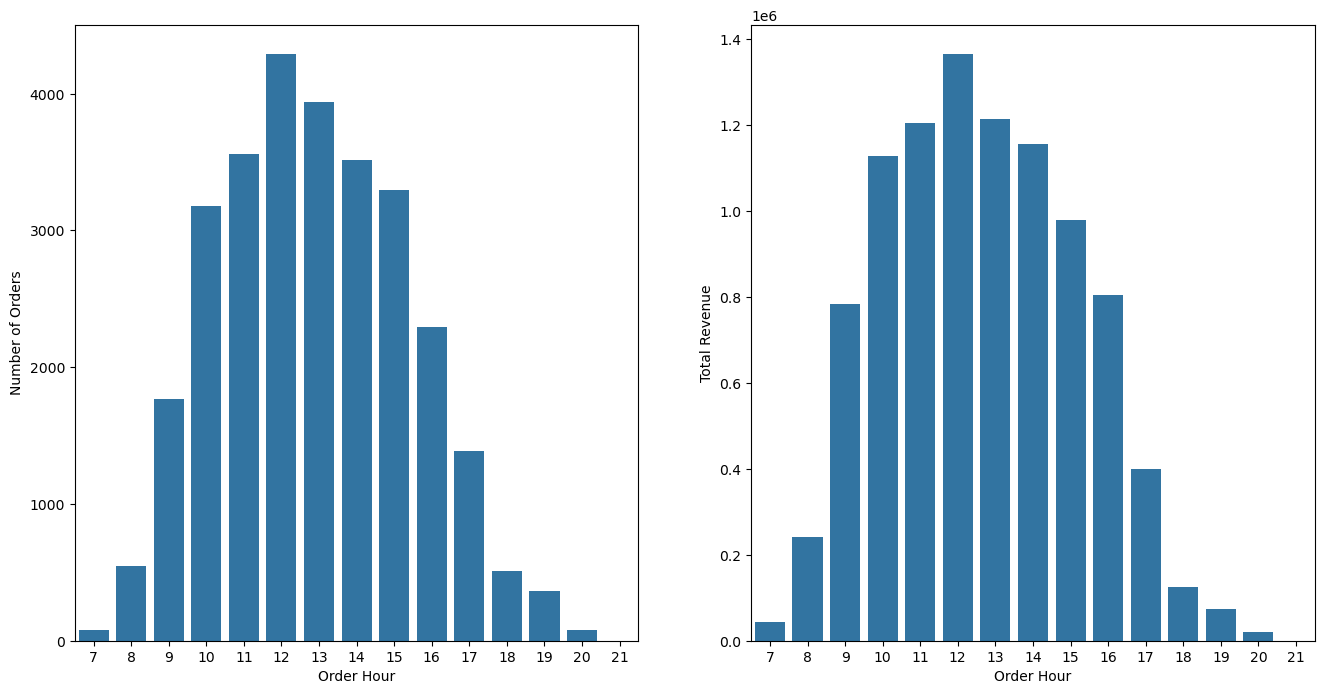

In [221]:
## creating two barplots: one for Number of Orders received and another for Total Revenue Generated
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (16,8))
g = sns.barplot(x = rush_hour['InvoiceHour'],
                y = rush_hour['N_Orders'],
                ax = axs[0])
g.set_ylabel("Number of Orders")
g.set_xlabel("Order Hour")

h = sns.barplot(x = rush_hour['InvoiceHour'],
                y = rush_hour['Total_Revenue'],
                ax = axs[1])
h.set_ylabel("Total Revenue")
h.set_xlabel("Order Hour")

plt.show()

Observations:

Apparently, the RUSH HOUR is from 12:00 PM to 02:00 PM for the business.
With this information, company's website can be better optimized for that specific time-period.
Also, we can make sure that the company avoids routine maintenance during the Rush Hour.
That way customer-bounce-rate can be minimized.

### Analyzing CustomerID

In [222]:
## total number of unique customers aquired by the business
df['Customer ID'].nunique()

4383

### Top 5 Most Valuable Customers

In [129]:
## fetching the top 5 customers by total revenue generated by the business from them 
df.groupby('Customer ID').agg({'InvoicedPrice':'sum'}).sort_values('InvoicedPrice', ascending = False).reset_index().rename({"InvoicedPrice":"Total_Revenue"}, axis = 1).head()

,Customer ID,Total_Revenue
0,18102,349164.35
1,14646,248396.50
2,14156,196549.74
3,14911,152121.22
4,13694,131443.19


### Average Spent

In [223]:
## fetching the descriptive stats to understand customers' spending
df.groupby("Invoice").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'TotalSpent'}, axis=1)['TotalSpent'].describe()

count    28816.000000
mean       331.048190
std       1142.798506
min     -53594.360000
25%          0.000000
50%        179.950000
75%        384.277500
max      49844.990000
Name: TotalSpent, dtype: float64

In [224]:
## checking the skewness of the distribution of total spent by customers
df.groupby("Invoice").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'TotalSpent'}, axis=1)['TotalSpent'].skew()

4.071221337337669

Observations:

75% customers spent less than 384.
Highest Customer Spent: 49844
Since the distribution is heavily right-skewed, it's safe to say most customers on the platforms spend less than 179.

###  RFM Analysis

RFM analysis is a strategic approach used by businesses, including online retail stores, to gain deep insights into customer behavior and optimize various aspects of operations. 
The acronym RFM stands for Recency, Frequency, and Monetary Value, which are fundamental metrics used to assess customer engagement, loyalty, and value to the business.

#### Recency (R): This factor evaluates how recently a customer has interacted or transacted with the business. It helps identify active and engaged customers versus those who may need re-engagement strategies.

#### Frequency (F): Frequency measures how often a customer engages with the business within a specific timeframe. It indicates customer loyalty, repeat purchases, and the potential for ongoing revenue generation.

#### Monetary Value (M): Monetary value reflects the total amount of money a customer has spent on products or services. It highlights high-value customers who contribute significantly to revenue and profitretail landscape.

In [264]:
## creating a separate dataframe aggregating customer information like last date of order, total orders, and total sum spent
customers = df.groupby("Customer ID").agg({'InvoiceDate':'max', 'Invoice': 'count', 'InvoicedPrice': 'sum'}).reset_index().rename(columns = {'InvoiceDate': 'LastOrderOn', 'Invoice':'N_Orders', 'InvoicedPrice': 'TotalSpent'})

In [265]:
customers.head(5)

,Customer ID,LastOrderOn,N_Orders,TotalSpent
0,12346.0,2010-10-04 16:33:00,46,-64.68
1,12347.0,2010-12-07 14:57:00,71,1323.32
2,12348.0,2010-09-27 14:59:00,20,222.16
3,12349.0,2010-10-28 08:23:00,107,2646.99
4,12351.0,2010-11-29 15:23:00,21,300.93


In [266]:
## Supposing the analysis is being done on the day after the last order was placed
analysis_date = customers['LastOrderOn'].max() + pd.Timedelta(days=1)

In [267]:
## creating a new column that quantifies the number of days since the user placed the last order
customers['LastOrderSince'] = (analysis_date - customers['LastOrderOn']).dt.days

In [268]:
## fetching the descriptive stats for the numeric columns of the customer dataframe
customers.describe(exclude = ['datetime64', 'object']).transpose()

,count,mean,std,min,25%,50%,75%,max
Customer ID,4383.0,15350.611453,1700.737934,12346.00,13880.50,15354.00,16837.00,18287.00
N_Orders,4383.0,95.262149,204.903882,1.00,18.00,44.00,103.00,5710.00
TotalSpent,4383.0,1904.679118,8519.369281,-25111.09,285.26,655.94,1645.69,341776.73
LastOrderSince,4383.0,91.395163,98.176493,1.00,17.00,52.00,138.00,374.00


In [269]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer ID     4383 non-null   float64       
 1   LastOrderOn     4383 non-null   datetime64[ns]
 2   N_Orders        4383 non-null   int64         
 3   TotalSpent      4383 non-null   float64       
 4   LastOrderSince  4383 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 171.3 KB


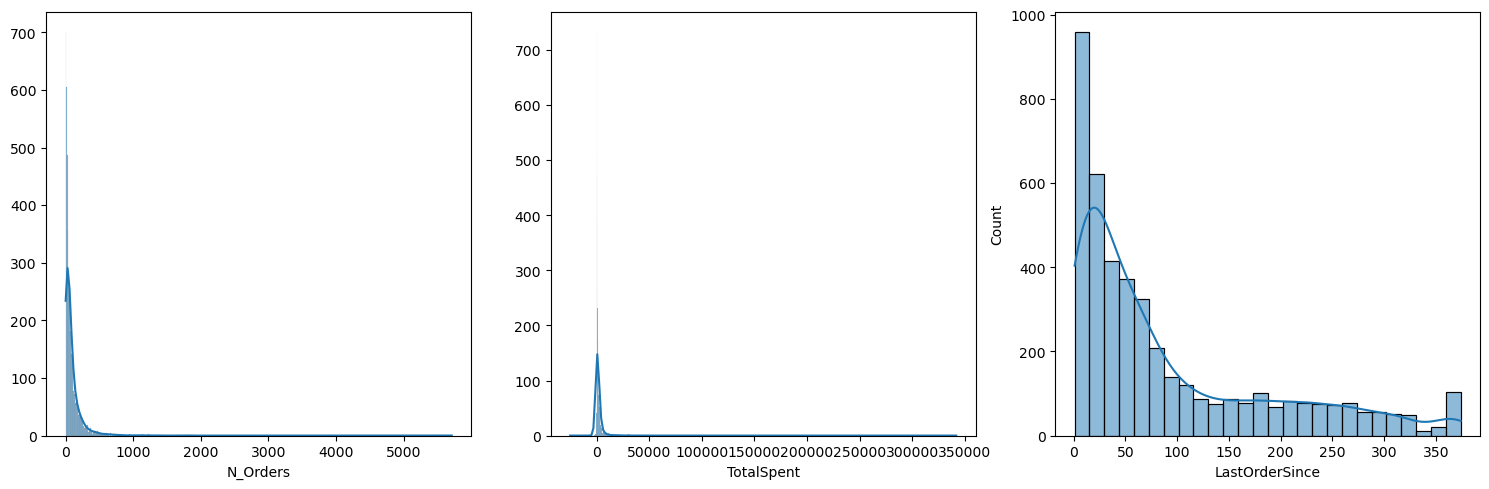

In [270]:
## creating three histograms to understand the underlying distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

## for N_Orders
sns.histplot(data = customers, x = 'N_Orders', kde = True, ax = axs[0])
axs[0].set_ylabel('')
## for TotalSpent
sns.histplot(data = customers, x = 'TotalSpent', kde = True, ax = axs[1])
axs[1].set_ylabel('')
## for LastOrderSince
sns.histplot(data = customers, x = 'LastOrderSince', kde = True, ax = axs[2])
axs[0].set_ylabel('')
## adjusting layout
plt.tight_layout()
plt.show()


In [271]:
for col in customers.drop(['Customer ID', 'LastOrderOn'], axis = 1).columns:
    print(f"Skewness for {col}: {np.round(customers[col].skew(),2)}")

Skewness for N_Orders: 12.79
Skewness for TotalSpent: 24.68
Skewness for LastOrderSince: 1.27


Note: All columns are right-skewed.

Plan of Action:

We'll bucket each column based on the quantile value to assign a score for Recency(R), Frequency(F) and Monetary(M).
We'll aggregate these scores for Customer Segmentation.

In [272]:
## for calculation the R, F and M off the columns
def calculateScore(value, col, reverse = False):
    if value <= customers[col].quantile(0.1):
        return 1 if not reverse else 10
    elif value <= customers[col].quantile(0.2):
        return 2 if not reverse else 9
    elif value <= customers[col].quantile(0.3):
        return 3 if not reverse else 8
    elif value <= customers[col].quantile(0.4):
        return 4 if not reverse else 7
    elif value <= customers[col].quantile(0.5):
        return 5 if not reverse else 6
    elif value <= customers[col].quantile(0.6):
        return 6 if not reverse else 5
    elif value <= customers[col].quantile(0.7):
        return 7 if not reverse else 4
    elif value <= customers[col].quantile(0.8):
        return 8 if not reverse else 3
    elif value <= customers[col].quantile(0.9):
        return 9 if not reverse else 2
    else:
        return 10 if not reverse else 1

In [273]:
## calculating R
customers['R'] = customers['LastOrderSince'].apply(calculateScore, col = 'LastOrderSince', reverse = True)

In [274]:
## calculating F
customers['F'] = customers['N_Orders'].apply(calculateScore, col = 'N_Orders', reverse = False)

In [275]:
## calculating M
customers['M'] = customers['TotalSpent'].apply(calculateScore, col = 'TotalSpent', reverse = False)

In [276]:
## summing these three to get RFM score
customers['RFM_Score'] = customers['R'] + customers['F'] + customers['M']

In [277]:
## fetching the descriptive stats for the RFM_score
customers['RFM_Score'].describe()

count    4383.000000
mean       16.505362
std         7.395023
min         3.000000
25%        10.000000
50%        16.000000
75%        23.000000
max        30.000000
Name: RFM_Score, dtype: float64

In [278]:
## creating bins based on percentile values
bins = [0, customers['RFM_Score'].quantile(1/3), customers['RFM_Score'].quantile(2/3), customers['RFM_Score'].max()]

## defining labels for the tiers
labels = ['Tier-III', 'Tier-II', 'Tier-I']

## adding a new column 'RFM_Tier' with the tier labels based on binning
customers['RFM_Tier'] = pd.cut(customers['RFM_Score'], bins=bins, labels=labels, include_lowest=True)

In [281]:
## aggregating the data by RFM_Tier
np.round(customers.groupby('RFM_Tier').agg({'Customer ID': 'count', 
                                            'LastOrderSince': 'mean', 
                                            'TotalSpent':'mean', 
                                            'N_Orders': 'mean',}).rename({'Customer ID': '#Customers', 
                                                                          'LastOrderSince': 'AvgInActiveDays', 
                                                                          'N_Orders': '#AvgOrders', 
                                                                          'TotalSpent':'AvgSpent', }), 2).sort_index()

C:\Users\admin\AppData\Local\Temp\ipykernel_34276\584488291.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  np.round(customers.groupby('RFM_Tier').agg({'Customer ID': 'count',


,Customer ID,LastOrderSince,TotalSpent,N_Orders
RFM_Tier,,,,
Tier-I,1447,23.38,4666.59,220.40
Tier-II,1288,67.17,957.80,54.02
Tier-III,1648,170.05,219.67,17.61


Benefits of RFM Analysis:
By combining these factors(R, F and M), businesses can create nuanced customer segments and tailor strategies beyond marketing, such as:

Operational Efficiency: Identifying high-frequency customers can inform inventory management, resource allocation, and service prioritization to enhance operational efficiency and customer satisfaction.

Customer Experience: Understanding the buying behavior of different segments enables personalized experiences, targeted promotions, and improved customer support, enhancing overall satisfaction and loyalty.

Product Development: Analyzing purchase patterns and preferences can guide product development, pricing strategies, and cross-selling initiatives to meet evolving customer needs effectively.

RFM analysis, therefore, serves as a powerful tool for data-driven decision-making across various business functions, driving growth, retention, and competitiveness in the dynamic online retail landscape.

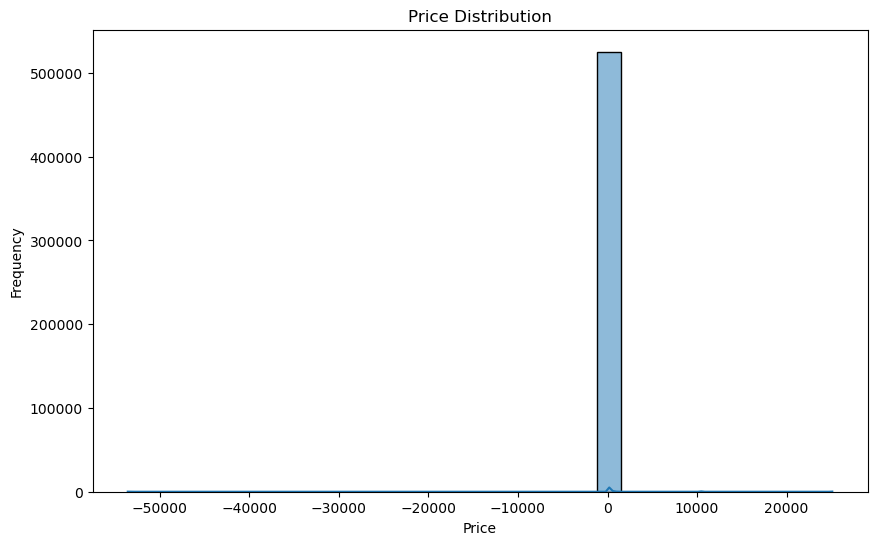

In [290]:
# Data preprocessing
# Assuming data cleaning and preprocessing steps have been performed beforehand

# Exploratory Data Analysis (EDA)
# Sales distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



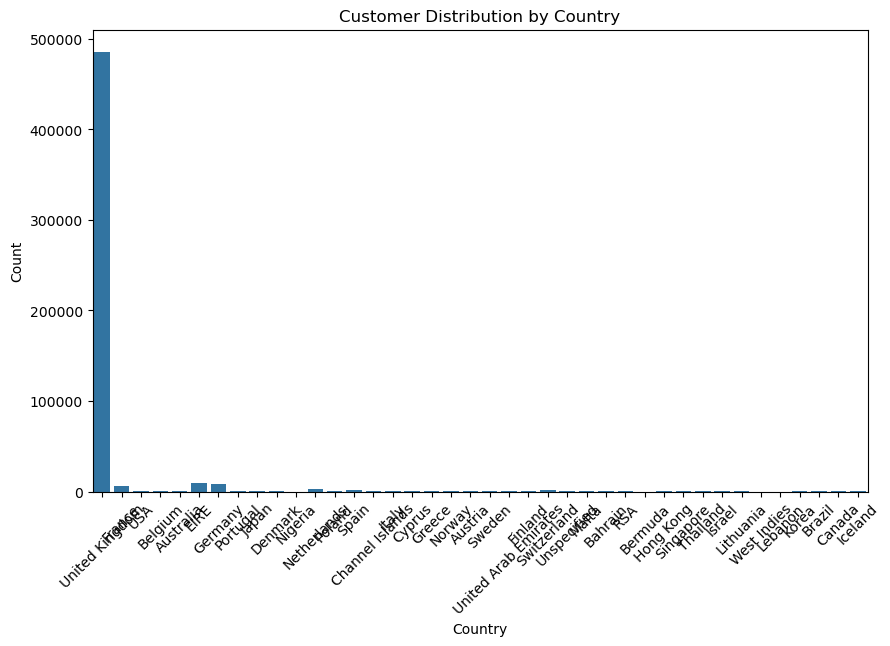

In [291]:

# Customer demographics
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', data=df)
plt.title('Customer Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



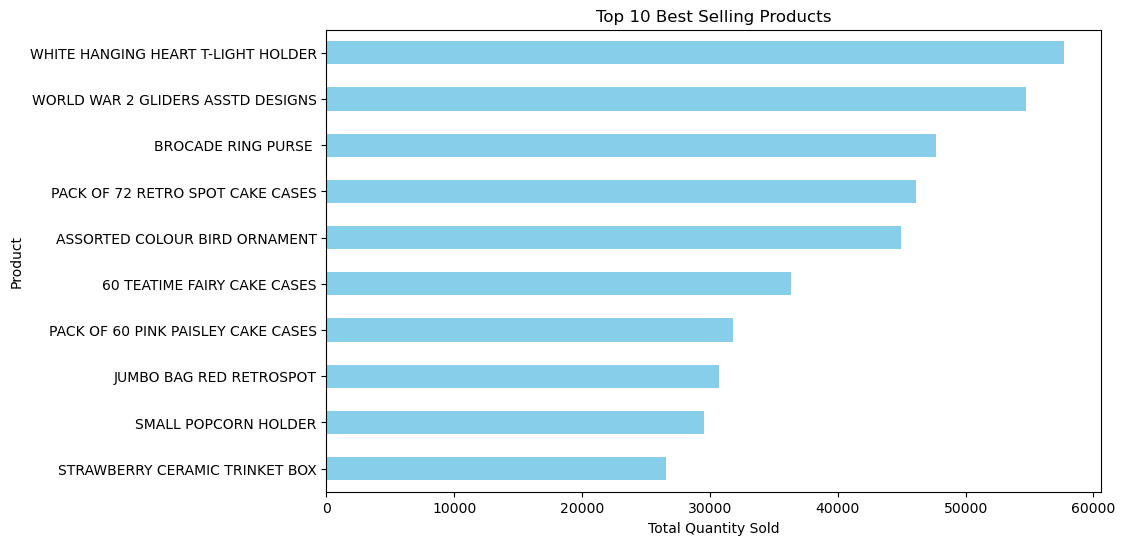

In [295]:
# Product analysis
top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='barh', color='skyblue')
plt.title('Top 10 Best Selling Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.gca().invert_yaxis()
plt.show()

